In [77]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import History

In [78]:
df = pd.read_csv("dialogs.txt", sep="\t")
a = pd.Series(df.columns)

In [79]:
df

,"hi, how are you doing?",i'm fine. how about yourself?
0,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
1,i'm pretty good. thanks for asking.,no problem. so how have you been?
2,no problem. so how have you been?,i've been great. what about you?
3,i've been great. what about you?,i've been good. i'm in school right now.
4,i've been good. i'm in school right now.,what school do you go to?
...,...,...
3719,that's a good question. maybe it's not old age.,are you right-handed?
3720,are you right-handed?,yes. all my life.
3721,yes. all my life.,you're wearing out your right hand. stop using...
3722,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.


In [80]:
a = a.rename({0: df.columns[0],1: df.columns[1]})
df.columns=['Questions','Answers']

In [81]:
df

,Questions,Answers
0,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
1,i'm pretty good. thanks for asking.,no problem. so how have you been?
2,no problem. so how have you been?,i've been great. what about you?
3,i've been great. what about you?,i've been good. i'm in school right now.
4,i've been good. i'm in school right now.,what school do you go to?
...,...,...
3719,that's a good question. maybe it's not old age.,are you right-handed?
3720,are you right-handed?,yes. all my life.
3721,yes. all my life.,you're wearing out your right hand. stop using...
3722,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.


In [82]:
questions, answers = zip(df)

In [83]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)

In [84]:
question_sequences = tokenizer.texts_to_sequences(questions)
answer_sequences = tokenizer.texts_to_sequences(answers)

In [85]:
max_seq_length = max(max(len(seq) for seq in question_sequences),
                     max(len(seq) for seq in answer_sequences))
question_sequences_padded = pad_sequences(question_sequences, maxlen=max_seq_length, padding='post')
answer_sequences_padded = pad_sequences(answer_sequences, maxlen=max_seq_length, padding='post')

In [86]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_seq_length),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(len(tokenizer.word_index) + 1, activation='softmax')
])

In [87]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [88]:
history = History()
model.fit(question_sequences_padded, answer_sequences_padded, epochs=150, batch_size=512, callbacks=[history])

Epoch 1/150


1/1 [==============================] - 1s 721ms/step - loss: 1.0347 - accuracy: 1.0000
Epoch 2/150
1/1 [==============================] - 0s 4ms/step - loss: 0.9846 - accuracy: 1.0000
Epoch 3/150
1/1 [==============================] - 0s 3ms/step - loss: 0.9356 - accuracy: 1.0000
Epoch 4/150
1/1 [==============================] - 0s 4ms/step - loss: 0.8876 - accuracy: 1.0000
Epoch 5/150
1/1 [==============================] - 0s 3ms/step - loss: 0.8405 - accuracy: 1.0000
Epoch 6/150
1/1 [==============================] - 0s 5ms/step - loss: 0.7941 - accuracy: 1.0000
Epoch 7/150
1/1 [==============================] - 0s 4ms/step - loss: 0.7483 - accuracy: 1.0000
Epoch 8/150
1/1 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 1.0000
Epoch 9/150
1/1 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 1.0000
Epoch 10/150
1/1 [==============================] - 0s 2ms/step - loss: 0.6141 - accuracy: 1.0000
Epoch 11/150
1/1 [=====================

In [89]:
loss, accuracy = model.evaluate(question_sequences_padded, answer_sequences_padded)
print("Accuracy:", accuracy)
print("Loss:", loss)

1/1 [==============================] - 0s 139ms/step - loss: 9.4512e-04 - accuracy: 1.0000
Accuracy: 1.0
Loss: 0.000945121340919286


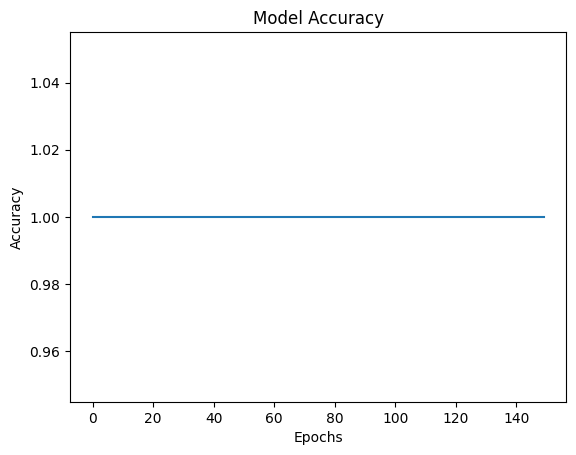

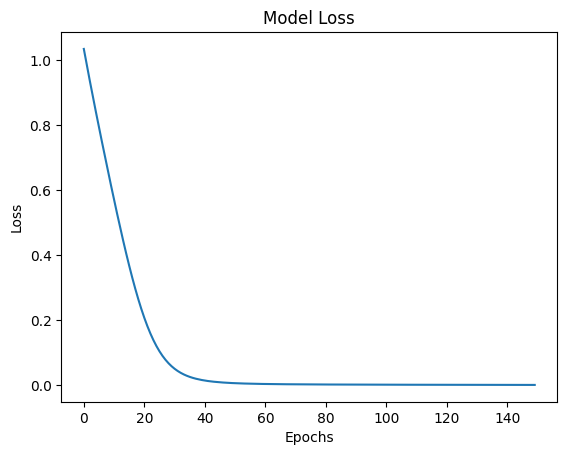

In [90]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()